In [ ]:
# Instalar pacotes necessários
!pip install yfinance pandas numpy scikit-learn matplotlib seaborn xgboost python-pptx -q

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from xgboost import XGBClassifier
from pptx import Presentation
from pptx.util import Inches, Pt
from datetime import datetime, timedelta

In [ ]:
# ===============================================
# 1. Coleta de dados
# ===============================================
df = yf.download("^BVSP", period="2y", interval="1d")
df.dropna(inplace=True)

/tmp/ipython-input-2811972915.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download("^BVSP", period="2y", interval="1d")
[*********************100%***********************]  1 of 1 completed


In [ ]:
# ===============================================
# 2. Engenharia de atributos
# ===============================================
df['Return'] = df['Close'].pct_change()
df['MA5'] = df['Close'].rolling(5).mean()
df['MA10'] = df['Close'].rolling(10).mean()
df['Volatility'] = df['Return'].rolling(10).std()
df.dropna(inplace=True)

In [ ]:
# Target: 1 = Alta, 0 = Baixa
df['Target'] = (df['Close'].shift(-1) > df['Close']).astype(int)

In [ ]:
# ===============================================
# 3. Preparação dos dados
# ===============================================
features = ['Close', 'Return', 'MA5', 'MA10', 'Volatility']
X = df[features]
y = df['Target']

In [ ]:
# Últimos 30 pregões = teste
X_train, X_test = X.iloc[:-30], X.iloc[-30:]
y_train, y_test = y.iloc[:-30], y.iloc[-30:]

In [ ]:

# ===============================================
# 4. Treinamento do modelo
# ===============================================
model = RandomForestClassifier(n_estimators=200, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=200, random_state=42)

In [ ]:
# ===============================================
# 5. Avaliação
# ===============================================
y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)

print("Acurácia no último mês:", round(acc*100,2), "%")
print("\nRelatório de Classificação:\n", classification_report(y_test, y_pred))
print("\nMatriz de Confusão:\n", confusion_matrix(y_test, y_pred))

Acurácia no último mês: 50.0 %

Relatório de Classificação:
               precision    recall  f1-score   support

           0       0.50      0.40      0.44        15
           1       0.50      0.60      0.55        15

    accuracy                           0.50        30
   macro avg       0.50      0.50      0.49        30
weighted avg       0.50      0.50      0.49        30


Matriz de Confusão:
 [[6 9]
 [6 9]]


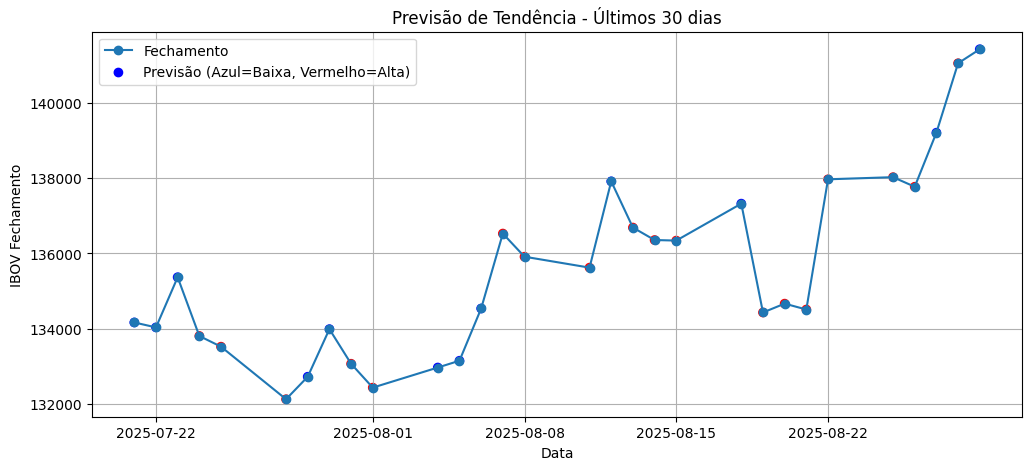

In [ ]:
# Gráfico de previsões no teste
plt.figure(figsize=(12,5))
plt.plot(df.index[-30:], df['Close'].iloc[-30:], marker='o', label="Fechamento")
plt.scatter(df.index[-30:], df['Close'].iloc[-30:],
            c=y_pred, cmap='bwr', label="Previsão (Azul=Baixa, Vermelho=Alta)")
plt.title("Previsão de Tendência - Últimos 30 dias")
plt.xlabel("Data")
plt.ylabel("IBOV Fechamento")
plt.legend()
plt.grid()
plt.savefig("previsoes_teste.png")
plt.show()

In [ ]:
# ===============================================
# 6. Projeção para os próximos 5 dias úteis
# ===============================================
projecoes = []
ultimo_dado = df.iloc[-1].copy()
hoje = df.index[-1]

for i in range(1, 6):  # próximos 5 dias
    prox_data = hoje + timedelta(days=i)
    while prox_data.weekday() >= 5:  # pula sábado/domingo
        prox_data += timedelta(days=1)

    X_input = ultimo_dado[features].values.reshape(1, -1)
    tendencia = model.predict(X_input)[0]

    projecoes.append({
        "Data": prox_data.strftime("%d/%m/%Y"),
        "Tendência": "↑ ALTA" if tendencia == 1 else "↓ BAIXA"
    })

    # atualizar para simular próximos dias (aqui mantemos valores estáticos, real seria via forecasting Close)
    ultimo_dado['Close'] *= (1 + np.random.normal(0, 0.01))  # simulação de variação
    ultimo_dado['Return'] = np.random.normal(0, 0.01)

projecoes_df = pd.DataFrame(projecoes)
print("\n📈 Projeções para os próximos dias:\n", projecoes_df)



📈 Projeções para os próximos dias:
          Data Tendência
0  01/09/2025   ↓ BAIXA
1  01/09/2025   ↓ BAIXA
2  01/09/2025   ↓ BAIXA
3  02/09/2025   ↓ BAIXA
4  03/09/2025   ↓ BAIXA


In [ ]:
# ===============================================
# . Modelo de Classificação
# ===============================================
clf = RandomForestClassifier(n_estimators=200, random_state=42)
clf.fit(X_train, y_train)
y_pred_class = clf.predict(X_test)

acc = accuracy_score(y_test, y_pred_class)

print("🔵 CLASSIFICAÇÃO (↑ ou ↓)")
print("Acurácia no último mês:", round(acc*100,2), "%")
print("\nRelatório de Classificação:\n", classification_report(y_test, y_pred_class))
print("\nMatriz de Confusão:\n", confusion_matrix(y_test, y_pred_class))

🔵 CLASSIFICAÇÃO (↑ ou ↓)
Acurácia no último mês: 50.0 %

Relatório de Classificação:
               precision    recall  f1-score   support

           0       0.50      0.40      0.44        15
           1       0.50      0.60      0.55        15

    accuracy                           0.50        30
   macro avg       0.50      0.50      0.49        30
weighted avg       0.50      0.50      0.49        30


Matriz de Confusão:
 [[6 9]
 [6 9]]


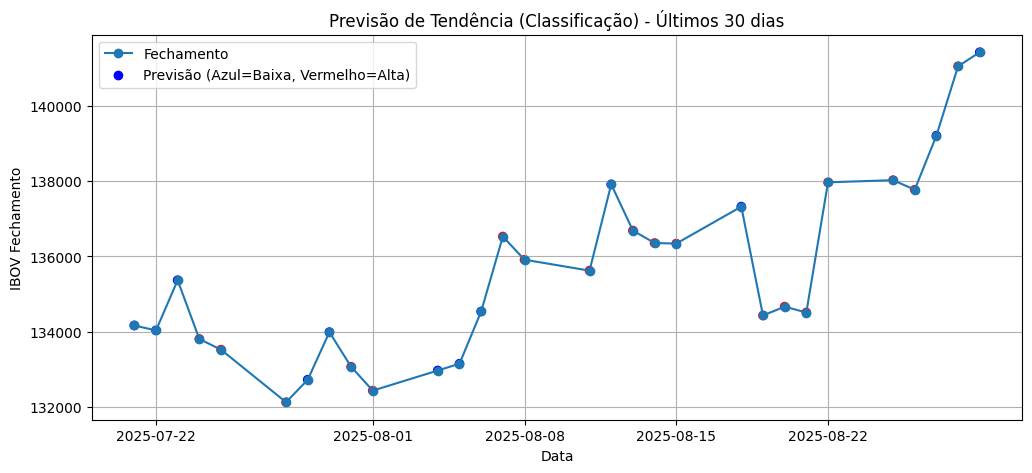

In [ ]:
# Gráfico - classificação
plt.figure(figsize=(12,5))
plt.plot(df.index[-30:], df['Close'].iloc[-30:], marker='o', label="Fechamento")
plt.scatter(df.index[-30:], df['Close'].iloc[-30:],
            c=y_pred_class, cmap='bwr', label="Previsão (Azul=Baixa, Vermelho=Alta)")
plt.title("Previsão de Tendência (Classificação) - Últimos 30 dias")
plt.xlabel("Data")
plt.ylabel("IBOV Fechamento")
plt.legend()
plt.grid()
plt.savefig("previsoes_class.png")
plt.show()

In [ ]:
# ---------- ) Preparação do conjunto de treino/teste ----------
d.dropna(inplace=True) # Remove linhas com NaN após criar todas as features

TEST_DAYS = 30
train = d.iloc[:-TEST_DAYS].copy()
test = d.iloc[-TEST_DAYS:].copy()


print(f"Tamanho treino: {len(train)}, tamanho teste: {len(test)}")


feature_cols = [
'return', 'log_return',
'return_lag_1','return_lag_2','return_lag_3','return_lag_4','return_lag_5',
'ma_5','ma_10','ma_20',
'std_5','std_10','std_20',
'ma_return_5','ma_return_10','ma_return_20',
'mom_5','mom_10','mom_20',
'dow_sin','dow_cos'
]


X_train = train[feature_cols]
y_train = train['target']
X_test = test[feature_cols]
y_test = test['target']

Tamanho treino: 696, tamanho teste: 30


In [ ]:
# ===============================================
# . Modelo de Regressão
# ===============================================
reg = RandomForestRegressor(n_estimators=200, random_state=42)
reg.fit(X_train, train['Close'].values.ravel())
y_pred_reg = reg.predict(X_test)

r2 = r2_score(test['Close'], y_pred_reg)
rmse = np.sqrt(mean_squared_error(test['Close'], y_pred_reg))

print("\n🟢 REGRESSÃO (Preço do IBOV)")
print("R² no último mês:", round(r2,4))
print("RMSE:", round(rmse,2))


🟢 REGRESSÃO (Preço do IBOV)
R² no último mês: 0.8041
RMSE: 962.6


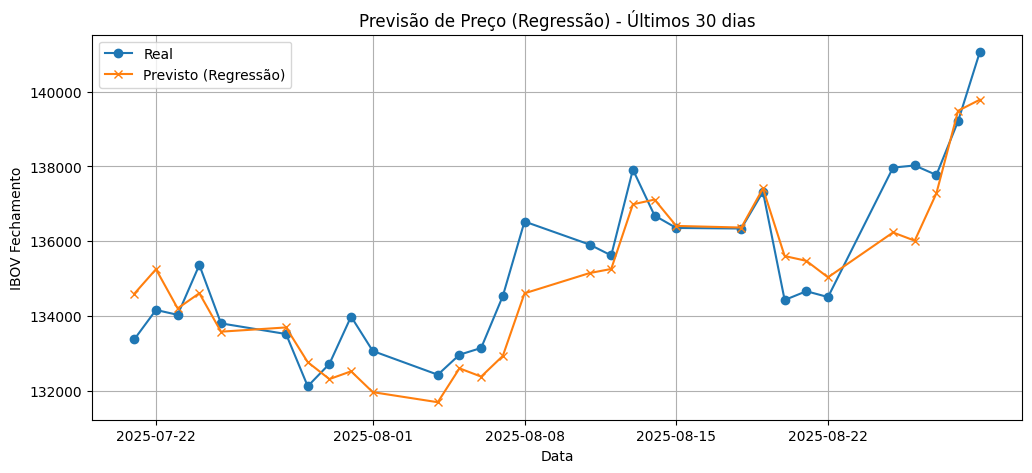

In [ ]:
# Gráfico - regressão
plt.figure(figsize=(12,5))
plt.plot(df.index[-30:], test['Close'], label="Real", marker='o')
plt.plot(df.index[-30:], y_pred_reg, label="Previsto (Regressão)", marker='x')
plt.title("Previsão de Preço (Regressão) - Últimos 30 dias")
plt.xlabel("Data")
plt.ylabel("IBOV Fechamento")
plt.legend()
plt.grid()
plt.savefig("previsoes_reg.png")
plt.show()